In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML513126931.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML144636971.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML247583641.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML274713521.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML127616381.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML142347381.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML69502641.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML515175311.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML408299711.jpg
/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Indian Roller/ML360682611.jpg
/kaggle/input/25-indian-bird-sp

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
data='/kaggle/input/25-indian-bird-species-with-226k-images/training_set'

In [7]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 22620 files belonging to 25 classes.
Using 18096 files for training.
Using 4524 files for validation.


In [11]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

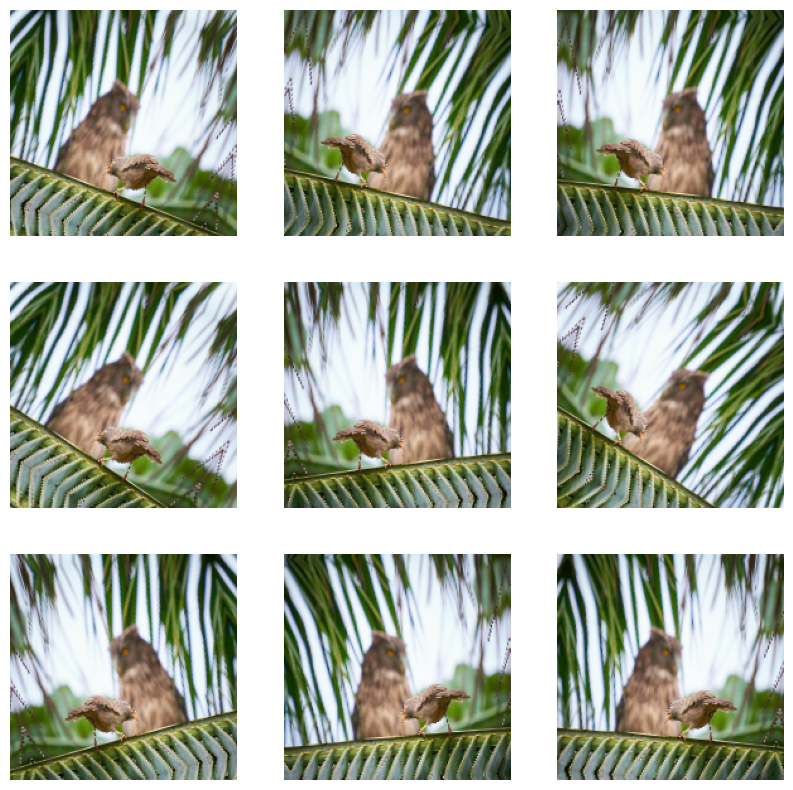

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

Ellipsis

In [10]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

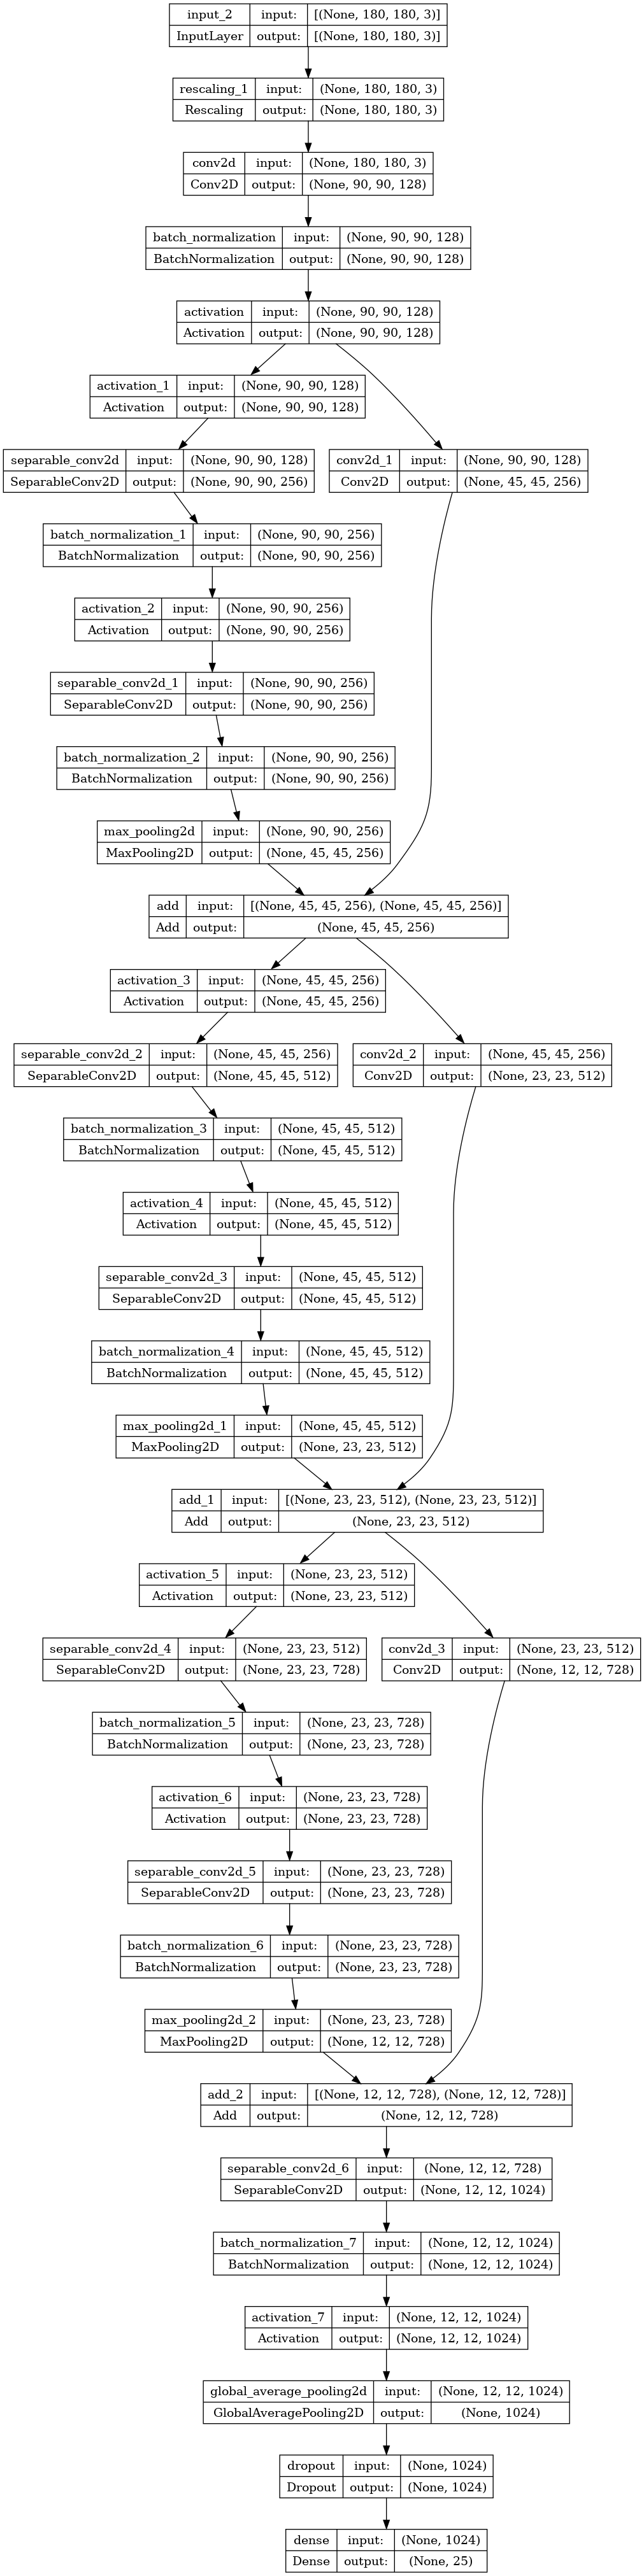

In [15]:
# Build a model


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 25:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(25, activation='softmax')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=25)
keras.utils.plot_model(model, show_shapes=True)


In [19]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
142/142 [==============================] - 312s 2s/step - loss: 0.1772 - accuracy: 0.9455 - val_loss: 0.9308 - val_accuracy: 0.8185
Epoch 2/20
142/142 [==============================] - 308s 2s/step - loss: 0.1561 - accuracy: 0.9535 - val_loss: 0.8272 - val_accuracy: 0.8050
Epoch 3/20
142/142 [==============================] - 305s 2s/step - loss: 0.1433 - accuracy: 0.9568 - val_loss: 0.8580 - val_accuracy: 0.7756
Epoch 4/20
142/142 [==============================] - 304s 2s/step - loss: 0.1326 - accuracy: 0.9601 - val_loss: 1.9636 - val_accuracy: 0.7005
Epoch 5/20
142/142 [==============================] - 309s 2s/step - loss: 0.1349 - accuracy: 0.9592 - val_loss: 0.7755 - val_accuracy: 0.8187
Epoch 6/20
142/142 [==============================] - 308s 2s/step - loss: 0.1304 - accuracy: 0.9613 - val_loss: 1.4533 - val_accuracy: 0.7310
Epoch 7/20
142/142 [==============================] - 306s 2s/step - loss: 0.1314 - accuracy: 0.9613 - val_loss: 0.9744 - val_accuracy: 0.8148

In [21]:
file_names = os.listdir(data)
file_names

['Indian Roller',
 'White-Breasted Waterhen',
 'Indian Grey Hornbill',
 'Common Myna',
 'Rufous Treepie',
 'Cattle Egret',
 'House Crow',
 'Ruddy Shelduck',
 'Gray Wagtail',
 'Forest Wagtail',
 'Common Tailorbird',
 'Sarus Crane',
 'White Wagtail',
 'Jungle Babbler',
 'Hoopoe',
 'Coppersmith Barbet',
 'Common Kingfisher',
 'Brown-Headed Barbet',
 'Indian Peacock',
 'Asian Green Bee-Eater',
 'Indian Pitta',
 'Red-Wattled Lapwing',
 'Northern Lapwing',
 'White-Breasted Kingfisher',
 'Common Rosefinch']

In [22]:
class_dict = {}
for i, name in enumerate(file_names):
    class_dict[i] = name
    
print(class_dict)

{0: 'Indian Roller', 1: 'White-Breasted Waterhen', 2: 'Indian Grey Hornbill', 3: 'Common Myna', 4: 'Rufous Treepie', 5: 'Cattle Egret', 6: 'House Crow', 7: 'Ruddy Shelduck', 8: 'Gray Wagtail', 9: 'Forest Wagtail', 10: 'Common Tailorbird', 11: 'Sarus Crane', 12: 'White Wagtail', 13: 'Jungle Babbler', 14: 'Hoopoe', 15: 'Coppersmith Barbet', 16: 'Common Kingfisher', 17: 'Brown-Headed Barbet', 18: 'Indian Peacock', 19: 'Asian Green Bee-Eater', 20: 'Indian Pitta', 21: 'Red-Wattled Lapwing', 22: 'Northern Lapwing', 23: 'White-Breasted Kingfisher', 24: 'Common Rosefinch'}


In [23]:
# sort the values in ascending order and get a list of tuples
sorted_names = sorted(class_dict.items(), key=lambda x: x[1])

# create a new dictionary with reindexed keys starting from 0
new_class_names = {}
for i, (key, value) in enumerate(sorted_names):
    new_class_names[i] = value
    
print(new_class_names)

{0: 'Asian Green Bee-Eater', 1: 'Brown-Headed Barbet', 2: 'Cattle Egret', 3: 'Common Kingfisher', 4: 'Common Myna', 5: 'Common Rosefinch', 6: 'Common Tailorbird', 7: 'Coppersmith Barbet', 8: 'Forest Wagtail', 9: 'Gray Wagtail', 10: 'Hoopoe', 11: 'House Crow', 12: 'Indian Grey Hornbill', 13: 'Indian Peacock', 14: 'Indian Pitta', 15: 'Indian Roller', 16: 'Jungle Babbler', 17: 'Northern Lapwing', 18: 'Red-Wattled Lapwing', 19: 'Ruddy Shelduck', 20: 'Rufous Treepie', 21: 'Sarus Crane', 22: 'White Wagtail', 23: 'White-Breasted Kingfisher', 24: 'White-Breasted Waterhen'}


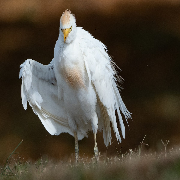

In [24]:
import numpy as np
import keras.utils as image


test_image=image.load_img('/kaggle/input/25-indian-bird-species-with-226k-images/training_set/Cattle Egret/ML105375011.jpg',target_size=image_size)
test_image

In [25]:
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
predictions = model.predict(test_image)  # Run inference on new data
# Convert the predictions to their specific classes
predicted_classes = np.argmax(predictions, axis=1)

# Print the original predictions and the predicted classes
print("Predictions:\n", predictions)
print("Predicted Classes:\n", predicted_classes)

1/1 [==============================] - 0s 475ms/step
Predictions:
 [[3.2471570e-13 2.8557898e-17 9.9998343e-01 1.0409896e-14 7.7657120e-10
  7.0648661e-11 1.8374908e-15 7.9925081e-16 1.2675096e-14 3.0438663e-09
  1.5949127e-14 3.5322415e-08 1.4483136e-06 2.4474534e-07 7.2240625e-19
  6.7920900e-15 9.6841122e-09 1.8181026e-13 3.0033316e-08 1.2136159e-11
  1.1391031e-13 1.3905276e-05 8.7579497e-07 2.3524594e-12 5.1402142e-12]]
Predicted Classes:
 [2]


In [26]:
for key,value in new_class_names.items():
    if predicted_classes[0] == int(key):
        print(f"The predicted class is {value}.")

The predicted class is Cattle Egret.


In [30]:
def predict(test_image, target_size=image_size):
    test_image=image.img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    predictions = model.predict(test_image)  # Run inference on new data
    # Convert the predictions to their specific classes
    predicted_classes = np.argmax(predictions, axis=1)

    # Print the original predictions and the predicted classes
    #print("Predictions:\n", predictions)
    #print("Predicted Classes:\n", predicted_classes)
    for key,value in new_class_names.items():
        if predicted_classes[0] == int(key):
            return {value}

In [39]:
model.save('model.h5')

In [37]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 128)  3584        ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 128)  512        ['conv2d[0][0]']             

In [41]:
model.save('bird_classifier')